<a href="https://colab.research.google.com/github/park-yeon-ju/Caloric-Calculator/blob/main/linear_feature_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import sys #파이썬 인터프리터를 제어할 수 있는 방법을 제공
import yaml
from torchvision import transforms, datasets
import torchvision
import numpy as np
import os
import tensorflow as tf

from sklearn import preprocessing
from torch.utils.data.dataloader import DataLoader

#구글 드라이브에 있는 폴더 import 할 수 있도록 권한 부여
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/yeonju_byol/PyTorch-BYOL')
from models.resnet_base_network import ResNet18
#ResNet18 네트워크 import

In [ ]:
batch_size = 256 
#config 파일이랑 동일하게 바꿔줌
#loader 코드에서 사용됨

data_transforms = torchvision.transforms.Compose([transforms.ToTensor()])
#데이터를 tensor로 바꾸는 과정

In [ ]:
config = yaml.load(open("/content/drive/MyDrive/Colab Notebooks/yeonju_byol/PyTorch-BYOL/config/config.yaml", "r"), Loader=yaml.FullLoader)

In [ ]:
train_dataset = datasets.STL10('/content/drive/MyDrive/Colab Notebooks/yeonju_byol/Downloads/', split='train', download=True,
                               transform=data_transforms)

test_dataset = datasets.STL10('/content/drive/MyDrive/Colab Notebooks/yeonju_byol/Downloads/', split='test', download=True,
                               transform=data_transforms) 
# 최초 다운로드 시에만 downlad=True로 변경

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print("Input shape:", train_dataset[0][0].shape)
#input shape이 96*96 3차원 이미지 파일 - color니까

Input shape: torch.Size([3, 96, 96])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          num_workers=0, drop_last=False, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size,
                          num_workers=0, drop_last=False, shuffle=True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
encoder = ResNet18(**config['network'])
#byol 인코더 네트워크 설정
output_feature_dim = encoder.projetion.net[0].in_features
#resnet18의 마지막 노드 개수?

cpu


In [ ]:
#load pre-trained parameters
load_params = torch.load(os.path.join('/content/drive/MyDrive/Colab Notebooks/yeonju_byol/PyTorch-BYOL/runs/b 256, e 400 _ 2/checkpoints/model.pth'),
                         map_location=torch.device(torch.device(device)))
# runs폴더에서 불러올 Training된 model설정

if 'online_network_state_dict' in load_params:
    encoder.load_state_dict(load_params['online_network_state_dict'])
    #path 파일에 있는 가중치 값들을 load.state_dict로 불러와 encoder 구조에 적용
    print("Parameters successfully loaded.")

# remove the projection head
encoder = torch.nn.Sequential(*list(encoder.children())[:-1])    
encoder = encoder.to(device)

Parameters successfully loaded.


In [ ]:
encoder

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

In [ ]:
logreg = LogisticRegression(output_feature_dim, 10)
logreg = logreg.to(device)

In [ ]:
def get_features_from_encoder(encoder, loader):
    
    x_train = []
    y_train = []

    # get the features from the pre-trained model
    for i, (x, y) in enumerate(loader):
        with torch.no_grad():
            feature_vector = encoder(x)
            x_train.extend(feature_vector)
            y_train.extend(y.numpy())

            
    x_train = torch.stack(x_train)
    y_train = torch.tensor(y_train)
    return x_train, y_train

In [ ]:
encoder.eval()
x_train, y_train = get_features_from_encoder(encoder, train_loader)
x_test, y_test = get_features_from_encoder(encoder, test_loader)

if len(x_train.shape) > 2:
    x_train = torch.mean(x_train, dim=[2, 3])
    x_test = torch.mean(x_test, dim=[2, 3])
    
print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)

Training data shape: torch.Size([5000, 512]) torch.Size([5000])
Testing data shape: torch.Size([8000, 512]) torch.Size([8000])


In [ ]:
def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test):

    train = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test, batch_size=512, shuffle=False)
    return train_loader, test_loader

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train).astype(np.float32)
x_test = scaler.transform(x_test).astype(np.float32)

In [ ]:
train_loader, test_loader = create_data_loaders_from_arrays(torch.from_numpy(x_train), y_train, torch.from_numpy(x_test), y_test)

In [ ]:
optimizer = torch.optim.Adam(logreg.parameters(), lr=3e-3)
criterion = torch.nn.CrossEntropyLoss()
eval_every_n_epochs = 10
testAC = []

for epoch in range(200):
#     train_acc = []
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()        
        
        logits = logreg(x)
        predictions = torch.argmax(logits, dim=1)
        
        loss = criterion(logits, y)
        
        loss.backward()
        optimizer.step()
    
    total = 0
    if epoch % eval_every_n_epochs == 0:
        correct = 0
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            logits = logreg(x)
            predictions = torch.argmax(logits, dim=1)
            
            total += y.size(0)
            correct += (predictions == y).sum().item()
            
        acc = 100 * correct / total
        print(f"Testing accuracy: {np.mean(acc)}")
      
        testAC.append(np.mean(acc))

Testing accuracy: 82.05
Testing accuracy: 82.7
Testing accuracy: 82.0875
Testing accuracy: 81.525
Testing accuracy: 81.2375
Testing accuracy: 80.85
Testing accuracy: 80.525
Testing accuracy: 80.7375
Testing accuracy: 80.2875
Testing accuracy: 80.1
Testing accuracy: 79.975
Testing accuracy: 79.7875
Testing accuracy: 79.925
Testing accuracy: 79.85
Testing accuracy: 79.8875
Testing accuracy: 79.8
Testing accuracy: 79.775
Testing accuracy: 79.625
Testing accuracy: 79.6125
Testing accuracy: 79.6625


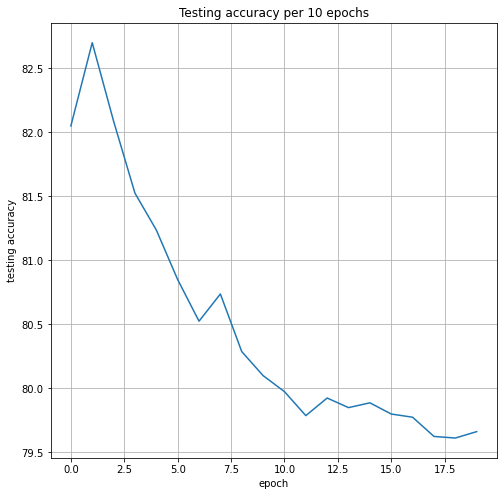

In [ ]:
#그래프를 그리기 위한 설정
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

plt.rcParams['figure.figsize'] = (8,8) #캔버스 가로 세로 길이 설정
plt.title('Testing accuracy per 10 epochs')
plt.xlabel('epoch')
plt.ylabel('testing accuracy')
#plt.legend(['test Accuracy',], loc='upper right')
plt.grid()

plt.plot(testAC)
plt.show()